# input to TABOO

In [13]:
import os
import shlex
import subprocess
import re

In [10]:
TABOO_DIR = "../src/models/TABOO"
os.chdir(TABOO_DIR)

FileNotFoundError: [Errno 2] No such file or directory: '../src/models/TABOO'

Radius, r−    Radius, r+      Density, ρ    Rigidity, µ     Viscosity, η    Layer <br>
(km)                 (km)        (kg m−3)     (Pa ×1011)     (Pa s ×1021)<br>
6281.000          6371.000        3192.800               0.596                               LT
6151.000          6281.000        3369.058               0.667                     0.5     UM1
5971.000          6151.000        3475.581               0.764                     0.5     UM2
5701.000          5971.000        3857.754               1.064                     0.5     TZ1
5401.000          5701.000        4446.251               1.702                     1.5     LM1
5072.933          5401.000        4615.829               1.912                     3.2     LM2
4716.800          5072.933        4813.845               2.124                     3.2     LM3
4332.600          4716.800        4997.859               2.325                     3.2     LM4
3920.333          4332.600        5202.004               2.554                     3.2     LM5
3480.000          3920.333        5408.573               2.794                     3.2     LM6
0                       3480.000     10 931.731                      0                        0     
Core


Table 2. Density, rigidity, and viscosity profiles adopted in the rheological VM5i model, where abbreviations LT, UM, TZ, and LM stand
for lithosphere, upper mantle, transition zone, and lower mantle, respectively. The radii r- and r+ indicate the lower and upper radii of each
layer. Some spectral properties of the VM5i model are given in Fig. 3 and Table 3.

In [19]:
# BASIC_CONF = {"LMIN": 2, "LMAX": 512, "VERBOSE": 1, "ONLY_ELASTIC": 0, "I_LOADING": 1}
BASIC_CONF = {"LMIN": 2, "LMAX": 512, "VERBOSE": 1, "I_LOADING": 1}

#VISCO from bottom to top *1e21
# VM5a (5 layer model top -> bottom) [1.5, 1.25, 0.75, 0.75, 10, 0.0, 0.0, 0.0, 0.0]
# 9L [3.2, 3.2, 3.2, 3.2, 3.2, 1.5, 0.5, 0.5, 0.5]
MAKE_MODEL = {
    "NV": 5,
    "CODE": 0,
    "THICKNESS_LITHOSPHERE": 90.0,
    "CONTROL_THICKNESS": 0,
    "VISCO": [1.5, 1.25, 0.75, 0.75, 10, 0.0, 0.0, 0.0, 0.0],
}


def TABOO_task_1(BASIC_CONF: dict, MAKE_MODEL: dict) -> None:
    NORMALIZED_RESIDUALS = {
        "IH_RES": 1,
        "IL_RES": 0,
        "IK_RES": 0,
    }
    EL_VLUID_VISCEL = {"H_EL": 1, "L_EL": 0, "K_EL": 0}

    HEAVISIDE_TH = {
        "N_HARM_DEG": 2,
        "H_LMIN": 2,
        "H_LMAX": 26,
        "LB_WINDOW": "1e-3",
        "UB_WINDOW": "1e+5",
        "N_POINTS": 11,
        "H_HEAV": 1,
        "L_HEAV": 0,
        "K_HEAV": 0,
    }

    filename = "task_1_mod.dat"
    with open(filename, mode="r") as f:
        text = f.read()

    with open("task_1.dat", mode="w") as f:
        for k, v in BASIC_CONF.items():
            text = re.sub(r"\${}".format(k), str(v), text)

        for k, v in MAKE_MODEL.items():
            if k == "VISCO":
                for idx, item in enumerate(v):
                    text = re.sub(r"\$VISCO_{}".format(idx + 1), str(item), text)
            else:
                text = re.sub(r"\${}".format(k), str(v), text)

        for k, v in NORMALIZED_RESIDUALS.items():
            text = re.sub(r"\${}".format(k), str(v), text)

        for k, v in EL_VLUID_VISCEL.items():
            text = re.sub(r"\${}".format(k), str(v), text)

        for k, v in HEAVISIDE_TH.items():
            text = re.sub(r"\${}".format(k), str(v), text)

        f.seek(0)
        f.write(text)
        f.truncate()

        return


TABOO_task_1(BASIC_CONF, MAKE_MODEL)


In [20]:
command = "./TABOO.exe"
args = shlex.split(command)
print(args)
subprocess.run(args)

['./TABOO.exe']
 = = = = = = = = = = = = = = =
    Reading file task_1.dat   
 = = = = = = = = = = = = = = =
 > found KEYWORD  Harmonic_Degrees              
 Loading analysis
 Lmin and Lmax            2         512
 > found KEYWORD  Make_Model                    
 Building the model 
 Number of VE layers                 5
 Model CODE is                       0
 From input, the lithospheric thickness is      90.0000  km
 The ILM parameter (for NV=7 and 9) is set to     0
 Mantle viscosity from BOTTOM to TOP (/1E21) 
 Viscosity of layer   1 =    1.5000
 Viscosity of layer   2 =    1.2500
 Viscosity of layer   3 =    0.7500
 Viscosity of layer   4 =    0.7500
 Viscosity of layer   5 =   10.0000
 VM5a viscosity model (PREM-averaged)                            
 Lithosphere                  (40 <= LT <= 100 km) 
 Lower lithosphere               (Thick =   40 km) 
 Upper mantle                 (280 <= Thick <=340) 
 Transition zone                 (Thick =  250 km) 
 Lower mantle 1         

CompletedProcess(args=['./TABOO.exe'], returncode=0)

# Compute DISK

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
np.cos(np.pi)

-1.0

In [9]:
filename_hlove = "h.dat"

station_name = "KUAQ"
lat_station = 68.58700000
lon_station = -33.05270000

lat_glacier = 68.645056
lon_glacier = -33.029416


def read_hlove(filename: str):
    h = pd.read_csv(filename, skiprows=2, header=None, delim_whitespace=True)
    n_love = h.shape[0]
    h_love = np.zeros(n_love)
    h_love = h[1].values

    return h_love, n_love


def near_angular_distance(lat1, lon1, lat2, lon2):
    return np.sqrt((lat1 - lat2) ** 2 + (lon1 - lon2) ** 2)


# ar is load (index 1) and cr is location at station (index 2)
def CompuGamma(t1: float, f1: float, t2: float, f2: float):
    t1 = t1 * np.pi / 180
    t2 = t1 * np.pi / 180
    f1 = t1 * np.pi / 180
    f2 = t1 * np.pi / 180

    cosg = (np.cos(t1) * np.cos(t2)) + (np.sin(t1) * np.cos(t2) * np.cos(f1 - f2))

    if cosg > 1:
        cosg = 1
    else:
        cosg = -1

    gamma = np.arccos(cosg)
    return gamma


# Near field
def funcB(gamma, aread, hlove, nlove):
    aa = 6371e3  # Earth Radius in m
    ad = 26000e6  # ?
    rho = 1e3  # density of water or ice?
    ma = 5.9e24  # mass of earth
    DevMAX = 80000  # ?

    hmax = hlove[nlove - 1]  # be sure hlove should not be 1 longer eg. 0 at index 0
    zfac = np.pi / 180
    r = np.sqrt(aread / np.pi)
    coeff = 4 * np.pi * (aa**3) * rho / ma

    x = np.cos(gamma)

    # creo poly l
    polyl = np.zeros(DevMAX + 1)
    p0 = 1
    polyl[0] = p0
    p1 = x
    polyl[1] = p1

    for j in np.arange(1,DevMAX):
        p2 = ((2 * j + 1) * x * p1 - j * p0) / (j + 1)
        polyl[j + 1] = p2
        p0 = p1
        p1 = p2

    x = np.cos(r / aa)

    p0 = 1
    p1 = x
    toth = 0

    for j in np.arange(1, nlove):
        p2 = ((2 * j + 1) * x * p1 - j * p0) / (j + 1)
        pp = ((x * p1) - p2) / j
        elemh = hlove[j] * pp * polyl[j]
        toth = toth + elemh
        p0 = p1
        p1 = p2

    for j in range(nlove + 1, DevMAX):
        p2 = ((2 * j + 1) * x * p1 - j * p0) / (j + 1)
        pp = (((x * p1) - p2)) / j
        elemh = hmax * pp * polyl[j]
        toth = toth + elemh
        p0 = p1
        p1 = p2

    valore = (toth / 2) * coeff * 1e3

    return valore

# Far field
def funcC(gamma, aread, hlove, nlove):
    raise NotImplementedError()


In [10]:
np.arccos(1)

0.0

In [11]:
hlove, nlove = read_hlove(filename_hlove)

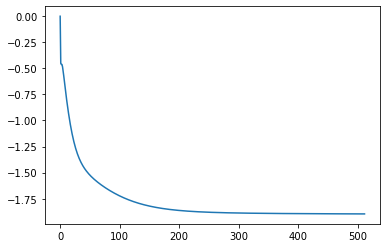

In [12]:
plt.plot(hlove)

In [13]:
hlove, nlove = read_hlove(filename_hlove)
gamma = CompuGamma(lat_glacier,lon_glacier, lat_station, lon_station)
near_ang_dist = np.sqrt((lat_glacier-lat_station)**2 + (lon_glacier-lon_station)**2)
arsurf = 10e5
ak = 6371e3 # same as aa
rj = np.sqrt(arsurf / np.pi)
if gamma >= (3 * rj / ak):
    valure = funcC(gamma, arsurf, hlove, nlove)
else:
    valore = funcB(gamma, arsurf, hlove, nlove)
    print(valore)


-0.04429589754973019


In [77]:
near_ang_dist*180/np.pi

3.583915719671672

In [78]:
gamma

0.0

In [74]:
np.cos(np.pi)

-1.0

In [ ]:
# pig = 4 * np.arctan2(1, 1)
pig = np.pi
ak = aa
print("start processing")

# filexyz = np.loadtxt(fname=fileoutxyz)
ntimes = 5
ngri = 5
nrec = 5
UGR = np.zeros((ngri, ntimes))
for i in range(ngri):
    for nt in range(ntimes):
        UGR[i, nt] = 0

    print("\t", "station point n: ", i, " of ", ngri)

    for j in range(nrec):
        print(j)

        gamma = CompuGamma(arlat[j], arlong[j], crlat[i], crlong[i], gamma)
        rj = np.sqrt(arsurf[j] / np.pi)

        if gamma >= (3 * rj / ak):
            funcC(gamma, arsurf[j], hlove, restmp, nlove)
        else:
            funcB(gamma, arsurf(j), hlove, restmp, nlove)

        for nt in range(ntimes):
            UGR[i, nt] = UGR[i, nt] + (restmp * armelt[j, jt])

    with open(file="out.txt", mode="w") as file:
        file.write(crlong[i], 90 - crlat[i], UGR[i, nt], nt=1, ntimes)

    print("end processing ... and writing results")

    for i in range(ngri):
        with open(file=dirout, mode="w") as file:
            for nt in range(ntimes):
                file.write(indext[nt], timeser[nt], UGR[i, nt])